This notebook is heavily based on the BWR example from https://nbviewer.org/github/mit-crpg/openmc-reactor-examples/blob/main/BWR.ipynb

In [1]:
%matplotlib inline
import openmc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import openmc.deplete

depletion_chain = '/data/user/albajacas_a/openmc-dev/chain_endfb71_pwr.xml'

fs = 15

# Material

## Zircaloy, steel, helium, and water

In [2]:
# Materials definitions

# Zr2 composition as described in https://www.matweb.com/search/datasheet_print.aspx?matguid=eb1dad5ce1ad4a1f9e92f86d5b44740d
zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.57)
zircaloy.add_element('Zr', 98.5, percent_type='wo')
zircaloy.add_element('Sn', 1.4, percent_type='wo')
zircaloy.add_element('O', 0.12, percent_type='wo')
zircaloy.add_element('Ni', 0.05, percent_type='wo')
zircaloy.add_element('Fe', 0.1, percent_type='wo')
zircaloy.add_element('Cr', 0.1, percent_type='wo')

# Plain Carbon Steel ASTM A516 Grade 70 as suggested in NTB 12-06, for the canisters.
# Numbers taken from https://www.ssab.com/en-us/brands-and-products/commercial-steel/pressure-vessel/astm-a516/grade-70
steel = openmc.Material(name='Carbon Steel')
steel.set_density('g/cm3', 7.85)
steel.add_element('Fe', 98.0, percent_type='wo')
steel.add_element('C', 0.25, percent_type='wo')
steel.add_element('Mn', 1.2, percent_type='wo')
steel.add_element('P', 0.02, percent_type='wo')
steel.add_element('S', 0.01, percent_type='wo')
steel.add_element('Si', 0.4, percent_type='wo')

# Helium for cladding gap.
helium = openmc.Material(name='Helium')
helium.add_element('He', 1)
helium.set_density('g/cm3', 0.178)  # Room temp density.

# Water
water = openmc.Material(name='Water')
water.set_density('g/cm3', 0.997)  # Room temperature water density.
water.add_element('H', 2)
water.add_element('O', 1)
water.add_s_alpha_beta('c_H_in_H2O')

## 64 different materials for rods

In [3]:
water_idxs = [0, 4, 21, 27, 32, 42, 44]

# Test water-rod placement
for i in range(8):
    print([1 if not (i*8+j in water_idxs) else 2 for j in range(8)])

[2, 1, 1, 1, 2, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 2, 1, 1]
[1, 1, 1, 2, 1, 1, 1, 1]
[2, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 2, 1, 2, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1]


In [4]:
# This should be changed to read the 64 rod materials from CASMO. In this example it's just fresh UO2 fuel.
def get_fuel_material():
    '''
    IC is a dataframe that contains a column for each pin, and a row for each isotopes.
    Each cell contains the weight percent of that element in this pin.
    Furthermore, it contains an extra column in front with isotope names e.g. U235
    and an extra row at the bottom with the material density in g/cm3.
    i is the fuel-pin index, an int in [0,63]
    '''
    
    if i in water_idxs:
        print("You have given me en i=", i, "that is a water rod.")
        return 0
            
    # This block is for fresh fuel. Uncomment if you want fresh UO2.
    local_mat = openmc.Material(name='fuel material number' + str(i))
    local_mat.set_density('g/cm3', 10.205)  # Fresh fuel density, from my CASMO file.
    local_mat.add_element('U', 1.0, enrichment=3.095)
    local_mat.add_element('O', 2.0)
    
    # Adding volume is necessary for depletion calculations.
    # Every pin_cell has same volume
    local_mat.volume = np.pi * 0.4645**2  # In cm2.
    
    return local_mat

materials = [get_fuel_material() if not (i in water_idxs) else "water" for i in range(64)]  # 57 rods + 7 water rods.
fuel_materials = [mat for mat in materials if mat != "water" ]

## Materials file

In [5]:
# Instantiate a Materials collection and export to xml. (water only needs to be instantiated once)
materials_file = openmc.Materials(fuel_materials +
                                  [zircaloy, steel, helium, water])
materials_file.export_to_xml()

### Colours for plots:

In [6]:
color_dict = {water: "blue", zircaloy: "grey", helium: "cyan", steel: "black"}
color_dict.update({mat: "orange" for mat in fuel_materials})

# Geometry

In [7]:
# Geometry definitions

In [8]:
pitch = 1.43
pin_cell_box = openmc.rectangular_prism(width=pitch, height=pitch)

## Water rods

In [9]:
# Geometry definitions for the water rod

water_or = openmc.ZCylinder(r=0.6505)
wclad_or = openmc.ZCylinder(r=0.6935)

wwater_inner_region = -water_or
wclad_region = -wclad_or & +water_or 
wwater_outer_region = pin_cell_box & +wclad_or

wwater_inner_cell = openmc.Cell(name='wwater_inner')
wwater_inner_cell.region = wwater_inner_region
wwater_inner_cell.fill = water

wclad_cell = openmc.Cell(name='wclad')
wclad_cell.fill = zircaloy
wclad_cell.region = wclad_region 

wwater_outer_cell = openmc.Cell(name='wwater_outer')
wwater_outer_cell.fill = water
wwater_outer_cell.region = wwater_outer_region

water_pin_universe = openmc.Universe(cells=[wwater_inner_cell, wclad_cell, wwater_outer_cell])

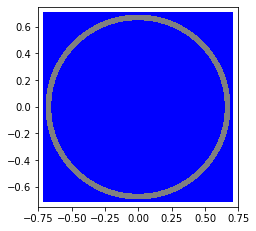

In [10]:
water_pin_universe.plot(width=(1.5, 1.5), color_by = "material", 
                           colors = color_dict)

## 64 different fuel rods

In [11]:
def get_fuel_universe(material):
    fuel_or  = openmc.ZCylinder(r=0.4645, name='Fuel OR')
    fclad_ir = openmc.ZCylinder(r=0.4742, name='Clad IR')
    fclad_or = openmc.ZCylinder(r=0.5360, name='Clad OR')

    fuel_region = -fuel_or 
    gap_region  = +fuel_or & -fclad_ir
    fclad_region  = +fclad_ir & -fclad_or
    fwater_region = pin_cell_box & +fclad_or

    gap_cell = openmc.Cell(name='air gap')
    gap_cell.fill = helium
    gap_cell.region = gap_region

    clad_cell = openmc.Cell(name='clad')
    clad_cell.fill = zircaloy
    clad_cell.region = fclad_region

    fwater_cell = openmc.Cell(name='fwater')
    fwater_cell.fill = water
    fwater_cell.region = fwater_region

    fuel_cell = openmc.Cell(name='fuel')
    fuel_cell.fill = material
    fuel_cell.region = fuel_region 
    local_universe = openmc.Universe(cells=[fuel_cell, gap_cell, clad_cell, fwater_cell])
    return local_universe

# fuel_pin_universe = openmc.Universe(cells=[fuel_cell, gap_cell, clad_cell, fwater_cell])

pin_universes = [water_pin_universe if mat == "water" else get_fuel_universe(mat) for mat in materials]


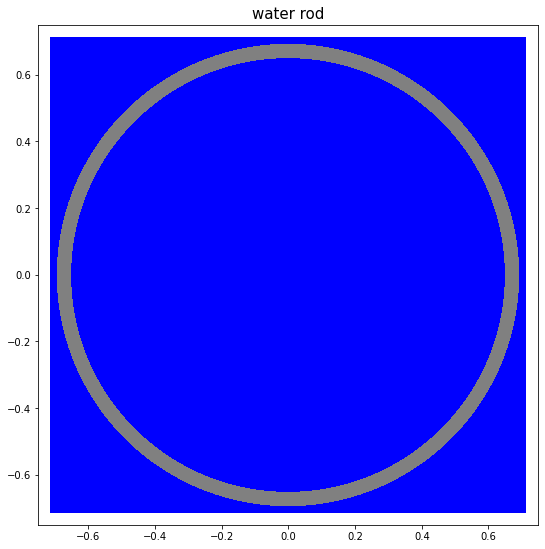

In [12]:
pin_universes[0].plot(width=(1.5, 1.5),color_by = "material", 
                           colors = color_dict, pixels = [500,500])
plt.title("water rod", fontsize = fs)
plt.show()

In [13]:
pin_universes[63].plot(width=(1.5, 1.5),color_by = "material", 
                           colors = color_dict, pixels = [500,500])
plt.title("fuel rod example", fontsize = fs)
plt.show()

## Assembly

In [14]:
# Defining an Assembly

In [15]:
sleave_IL = 23.5
sleave_OL = 26  # I don't actually know this, as it is not clear from the documents.

In [16]:
side_length = pitch * 15
print("Assembly side length =", side_length)

assembly = openmc.RectLattice(name='Assembly')
assembly.pitch = (pitch, pitch)
assembly.lower_left = [-side_length/2, -side_length/2]

assembly.universes = [
    pin_universes[56:64][::-1] + pin_universes[57:64],  # Top row
    pin_universes[48:56][::-1] + pin_universes[49:56],  # 2nd row
    pin_universes[40:48][::-1] + pin_universes[41:48],  # 3rd row
    pin_universes[32:40][::-1] + pin_universes[33:40],  # 4th row
    pin_universes[24:32][::-1] + pin_universes[25:32],  # 5th row
    pin_universes[16:24][::-1] + pin_universes[17:24],  # 6th row
    pin_universes[8:16][::-1] + pin_universes[9:16],  # 7th row
    pin_universes[0:8][::-1] + pin_universes[1:8],  # Centre row
    pin_universes[8:16][::-1] + pin_universes[9:16],  # 9th row
    pin_universes[16:24][::-1] + pin_universes[17:24],  # 10th row
    pin_universes[24:32][::-1] + pin_universes[25:32],  # 11th row
    pin_universes[32:40][::-1] + pin_universes[33:40],  # 12th row
    pin_universes[40:48][::-1] + pin_universes[41:48],  # 13rd row
    pin_universes[48:56][::-1] + pin_universes[49:56],  # 14nd row
    pin_universes[56:64][::-1] + pin_universes[57:64],  # Bottom row
]
print([len(row) for row in assembly.universes])

assembly_region = openmc.rectangular_prism(width=side_length, height=side_length, origin=(0,0))
assembly_cell = openmc.Cell(name='Assembly cell', fill=assembly, region=assembly_region)

assembly_water = openmc.Cell(name='Assembly water')
assembly_water.region = ~assembly_cell.region & openmc.rectangular_prism(width=sleave_IL, height=sleave_IL)
assembly_water.fill = water

assembly_sleave = openmc.Cell(name='Assembly sleave')
assembly_sleave.region = ~assembly_cell.region & ~assembly_water.region & openmc.rectangular_prism(width=sleave_OL, height=sleave_OL)
assembly_sleave.fill = zircaloy


assembly_universe = openmc.Universe(cells=[assembly_cell, assembly_water, assembly_sleave])

Assembly side length = 21.45
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]


In [17]:
fig, ax = plt.subplots(figsize = (17,17))
assembly_universe.plot(width=(28,28),color_by = "material", 
                       colors = color_dict, axes = ax, pixels = [500,500])

## Canister

In [18]:
canister_outer_radius = 55
can_ir = openmc.ZCylinder(r=41, name='Canister IR')
can_or = openmc.ZCylinder(r=canister_outer_radius, name='Canister OR')

canister_cell = openmc.rectangular_prism(width=2.1*canister_outer_radius, 
                                        height=2.1*canister_outer_radius,
                                        boundary_type='reflective')


FA_box = openmc.RectLattice(name='FA_box')
FA_box.pitch = (sleave_OL, sleave_OL)
FA_box.lower_left = [-sleave_OL, -sleave_OL]
FA_box.universes = [
    2*[assembly_universe],
    2*[assembly_universe],
]

FA_box_cell = openmc.Cell(name='FA box cell', fill=FA_box, 
                          region=openmc.rectangular_prism(width=2*sleave_OL, 
                                                          height=2*sleave_OL, origin=(0,0)))

can_steel = openmc.Cell(name='Canister steel')
can_steel.fill = steel
can_steel.region = +can_ir & -can_or

can_water = openmc.Cell(name='Water in canister')
can_water.fill = water
can_water.region = canister_cell & ~can_steel.region & ~FA_box_cell.region

canister_universe = openmc.Universe(cells=[FA_box_cell, can_water, can_steel])


 ## Reduce symmetry

Due to the 8-fold symmetry we can simplify the model

In [20]:
# Run this cell only if you want to divide geometry by 8.

xmirror = openmc.XPlane(boundary_type = 'reflective')
diagmirror = openmc.Plane(a = 1.0, b = -1.0, boundary_type = 'reflective')

FA_box_region = openmc.rectangular_prism(width=2*sleave_OL, height=2*sleave_OL, origin=(0,0))

FA_box_cell = openmc.Cell(name='FA box cell', fill=FA_box, 
                          region= +xmirror & -diagmirror & FA_box_region)

can_steel = openmc.Cell(name='Canister steel')
can_steel.fill = steel
can_steel.region = +xmirror & -diagmirror & +can_ir & -can_or 

can_water = openmc.Cell(name='Water in canister')
can_water.fill = water
can_water.region = +xmirror & -diagmirror & canister_cell & ~can_steel.region & ~FA_box_cell.region

canister_universe = openmc.Universe(cells=[FA_box_cell, can_water, can_steel])

## Save geometry

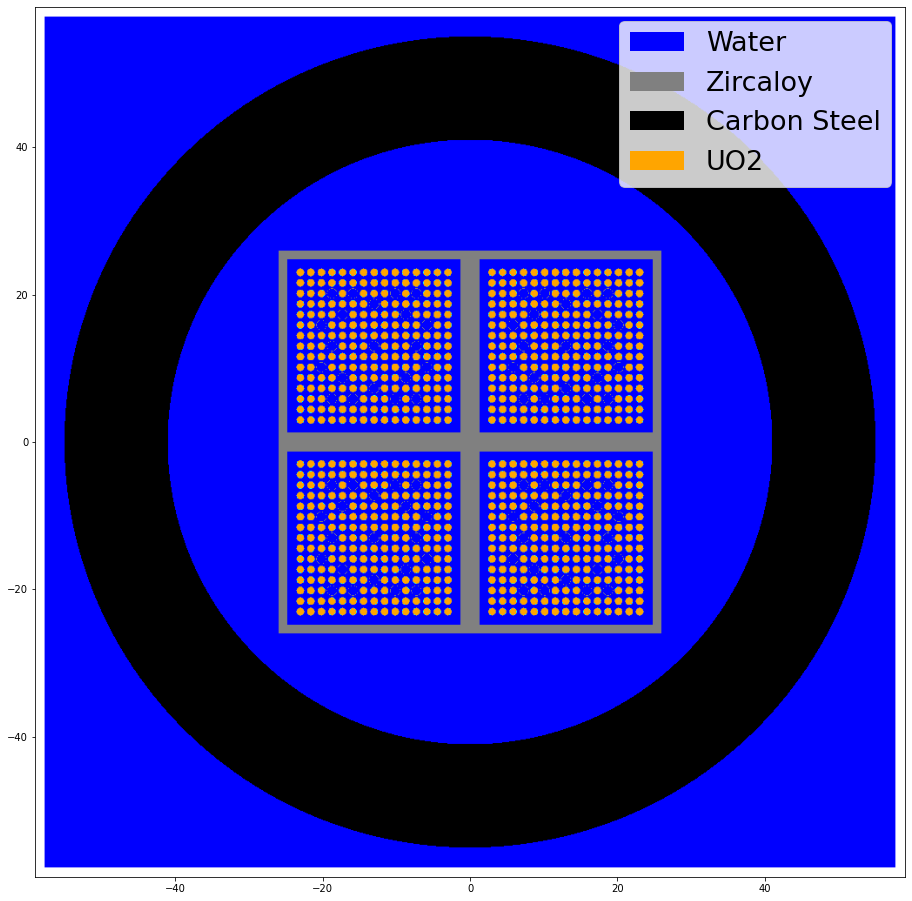

In [19]:
fig, ax = plt.subplots(figsize = (16,16))
canister_universe.plot(width=(118,118), color_by = "material", 
                       colors = color_dict, axes = ax, pixels = [1000,1000])

# Legend
# p = plt.Rectangle((0, 0), 1, 1, fc="r")
# ax.legend([p], ["Red Rectangle"])
# ax.legend([plt.Rectangle((0, 0), 1, 1, fc=col) for col in list(color_dict.values())[:4]],
#           [mat.name for mat in color_dict][:4], fontsize = 15)
ax.legend([plt.Rectangle((0, 0), 1, 1, fc=col) for col in ['blue', 'grey', 'black', 'orange']],
          [mat for mat in ['Water', 'Zircaloy', 'Carbon Steel', 'UO2']][:4], fontsize = 27)

# ax.grid()
# ax.set_xticks([])
# ax.set_yticks([])

# plt.savefig("plots/canister.pdf", format = 'pdf', bbox_inches='tight')
plt.show()

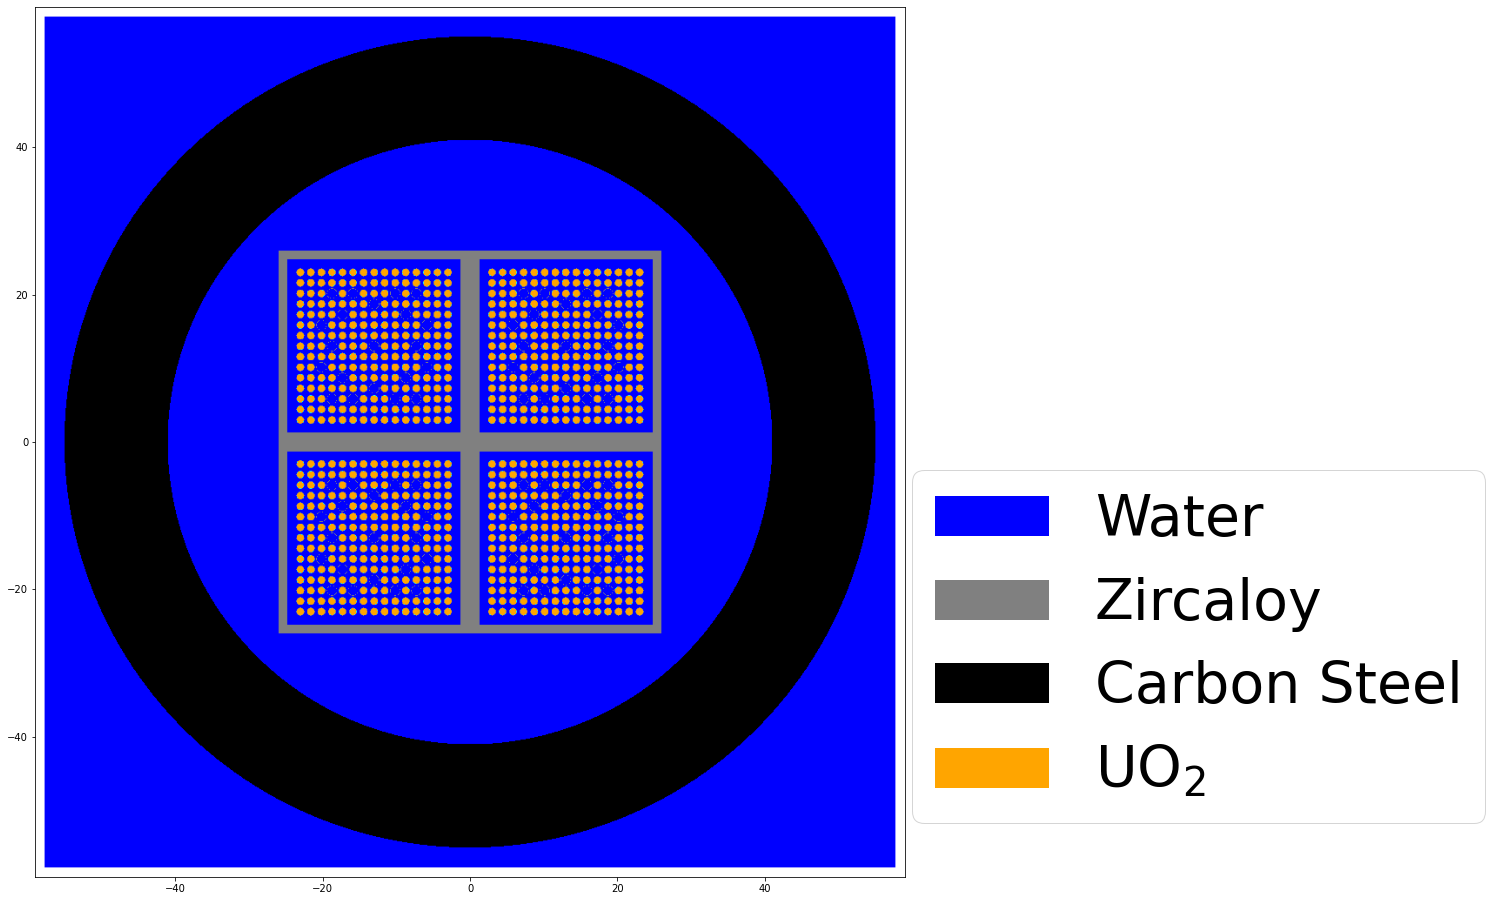

In [25]:
# Alternative plot
fig, ax = plt.subplots(figsize = (16,16))
canister_universe.plot(width=(118,118), color_by = "material", 
                       colors = color_dict, axes = ax, pixels = [1000,1000])

# Legend
# p = plt.Rectangle((0, 0), 1, 1, fc="r")
# ax.legend([p], ["Red Rectangle"])
# ax.legend([plt.Rectangle((0, 0), 1, 1, fc=col) for col in list(color_dict.values())[:4]],
#           [mat.name for mat in color_dict][:4], fontsize = 15)
ax.legend([plt.Rectangle((0, 0), 1, 1, fc=col) for col in ['blue', 'grey', 'black', 'orange']],
          [mat for mat in ['Water', 'Zircaloy', 'Carbon Steel', r'UO$_2$']][:4], fontsize = 57,
         loc='best', bbox_to_anchor=(1.7, 0.5))

# ax.grid()
# ax.set_xticks([])
# ax.set_yticks([])

plt.savefig("plots/canister_longPlot.pdf", format = 'pdf', bbox_inches='tight')
plt.show()

In [21]:
geom = openmc.Geometry(canister_universe)
geom.export_to_xml()

# Simulation k-eff

In [22]:
# OpenMC simulation parameters

settings = openmc.Settings()
settings.source = openmc.Source(space=openmc.stats.Point((10, 20, 0)))
settings.batches = 20
settings.inactive = 10
settings.particles = 1000
settings.seed = 42
settings.export_to_xml()

In [23]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [24]:
sp = openmc.StatePoint('statepoint.20.h5')
sp.keff

1.1071378710245894+/-0.00661348397762083

## Depletion calculations

In [23]:
model = openmc.model.Model(geometry = geom, materials = materials_file, settings = settings)

operator = openmc.deplete.CoupledOperator(model = model, 
                                          chain_file = depletion_chain)

timesteps = [1,5]  # At 1 and 6 years of cooling, calculate k-eff
power = 1e-200  # If you choose power=0 it won't do the k-eff calculations.
integrator = openmc.deplete.CECMIntegrator(operator, timesteps, power, timestep_units = 'a')

In [24]:
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mg24 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Mg24.h5
 Reading Mg25 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Mg25.h5
 Reading Mg26 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Mg26.h5
 Reading Al27 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Al27.h5
 Reading Cl35 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Cl35.h5
 Reading Cl37 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Cl37.h5
 Reading Ar36 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ar36.h5
 Reading Ar38 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ar38.h5
 Reading Ar40 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ar40.h5
 Reading K39 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/K39.h5


 Reading K40 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/K40.h5
 Reading K41 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/K41.h5
 Reading Ca40 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ca40.h5
 Reading Ca42 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ca42.h5
 Reading Ca43 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ca43.h5
 Reading Ca44 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ca44.h5
 Reading Ca46 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ca46.h5
 Reading Ca48 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ca48.h5
 Reading Sc45 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Sc45.h5
 Reading Ti46 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ti46.h5
 Reading Ti47 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ti47.h5
 Reading Ti48 

 Reading Br81 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Br81.h5
 Reading Kr78 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Kr78.h5
 Reading Kr80 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Kr80.h5
 Reading Kr82 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Kr82.h5
 Reading Kr83 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Kr83.h5
 Reading Kr84 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Kr84.h5
 Reading Kr85 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Kr85.h5
 Reading Kr86 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Kr86.h5
 Reading Rb85 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Rb85.h5
 Reading Rb86 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Rb86.h5
 Reading Rb87 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Rb87.h5
 Reading S

 Reading Mo95 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Mo95.h5
 Reading Mo96 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Mo96.h5
 Reading Mo97 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Mo97.h5
 Reading Mo98 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Mo98.h5
 Reading Mo99 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Mo99.h5


 Reading Mo100 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Mo100.h5
 Reading Tc99 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Tc99.h5
 Reading Ru96 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ru96.h5
 Reading Ru98 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ru98.h5
 Reading Ru99 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ru99.h5
 Reading Ru100 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ru100.h5
 Reading Ru101 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ru101.h5
 Reading Ru102 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ru102.h5
 Reading Ru103 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ru103.h5
 Reading Ru104 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ru104.h5
 Reading Ru105 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ru105

 Reading Cd108 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Cd108.h5
 Reading Cd110 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Cd110.h5
 Reading Cd111 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Cd111.h5
 Reading Cd112 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Cd112.h5
 Reading Cd113 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Cd113.h5
 Reading Cd114 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Cd114.h5
 Reading Cd115_m1 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Cd115_m1.h5
 Reading Cd116 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Cd116.h5
 Reading In113 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/In113.h5
 Reading In115 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/In115.h5
 Reading Sn113 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5

 Reading Sb123 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Sb123.h5
 Reading Sb124 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Sb124.h5
 Reading Sb125 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Sb125.h5
 Reading Sb126 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Sb126.h5
 Reading Te120 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Te120.h5
 Reading Te122 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Te122.h5
 Reading Te123 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Te123.h5
 Reading Te124 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Te124.h5
 Reading Te125 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Te125.h5
 Reading Te126 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Te126.h5
 Reading Te127_m1 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/ne

 Reading I135 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/I135.h5
 Reading Xe123 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Xe123.h5
 Reading Xe124 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Xe124.h5
 Reading Xe126 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Xe126.h5
 Reading Xe128 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Xe128.h5
 Reading Xe129 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Xe129.h5
 Reading Xe130 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Xe130.h5
 Reading Xe131 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Xe131.h5
 Reading Xe132 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Xe132.h5
 Reading Xe133 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Xe133.h5
 Reading Xe134 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron

 Reading Ba132 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ba132.h5
 Reading Ba133 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ba133.h5
 Reading Ba134 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ba134.h5
 Reading Ba135 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ba135.h5
 Reading Ba136 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ba136.h5
 Reading Ba137 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ba137.h5
 Reading Ba138 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ba138.h5
 Reading Ba140 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Ba140.h5
 Reading La138 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/La138.h5
 Reading La139 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/La139.h5
 Reading La140 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutr

 Reading Gd152 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Gd152.h5
 Reading Gd153 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Gd153.h5
 Reading Gd154 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Gd154.h5
 Reading Gd155 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Gd155.h5
 Reading Gd156 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Gd156.h5
 Reading Gd157 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Gd157.h5
 Reading Gd158 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Gd158.h5
 Reading Gd160 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Gd160.h5
 Reading Tb159 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Tb159.h5
 Reading Tb160 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Tb160.h5
 Reading Dy156 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutr

 Reading Np235 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Np235.h5
 Reading Np236 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Np236.h5
 Reading Np237 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Np237.h5
 Reading Np238 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Np238.h5
 Reading Np239 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Np239.h5
 Reading Pu236 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Pu236.h5
 Reading Pu237 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Pu237.h5
 Reading Pu238 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Pu238.h5
 Reading Pu239 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Pu239.h5
 Reading Pu240 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutron/Pu240.h5
 Reading Pu241 from
 /data/user/albajacas_a/openmc-dev/data/nndc-b7.1-hdf5/neutr

[openmc.deplete] t=31557600.0 s, dt=157788000.0 s, source=1e-200
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.06170
        2/1    1.10255
        3/1    1.06415
        4/1    1.07573
        5/1    1.06625
        6/1    1.12662
        7/1    1.11481
        8/1    1.11755
        9/1    1.15335
       10/1    1.10903
       11/1    1.06294
       12/1    1.15783    1.11038 +/- 0.04744
       13/1    1.13489    1.11855 +/- 0.02858
       14/1    1.14465    1.12508 +/- 0.02124
       15/1    1.09594    1.11925 +/- 0.01745
       16/1    1.13627    1.12209 +/- 0.01453
       17/1    1.14567    1.12546 +/- 0.01273
       18/1    1.07161    1.11873 +/- 0.01292
       19/1    1.16784    1.12418 +/- 0.01263
       20/1    1.11821    1.12359 +/- 0.01132
 Creating stat

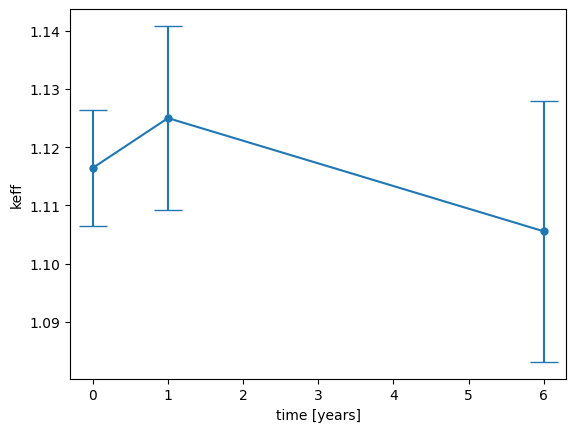

In [33]:
ts, ks = openmc.deplete.Results('depletion_results.h5').get_keff(time_units = 'a')

plt.errorbar(ts, ks[:,0], yerr = ks[:,1], capsize = 10, markersize = 5, marker = 'o')
plt.xlabel('time [years]')
plt.ylabel('keff')
plt.show()

In [32]:
ts, ats = openmc.deplete.Results('depletion_results.h5').get_atoms('5', 'U235', nuc_units = 'atom/cm3', time_units = 'a')
plt.plot(ts, ats, 'o')
plt.xlabel('time [years]')
plt.ylabel('U235 [at/cm3]')
plt.show()